# NLP Core 3 Exercise: Learning how to tweet from Trump

Training a character-level RNN language model in Keras in order to generate text, training on a dataset of tweets contributed by Donald Trump.

## Loading and cleaning the data

The accompanying file *trump_tweets.txt* contains a list of newline-separated Trump tweets. 

In [1]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.


**Loading the tweets into a Pandas Dataframe with column 'text'.**

In [2]:
df = pd.read_csv('trump_tweets.txt', sep='\n', names=['text'])

**Adding a new column 'cleaned' to the dataframe containing the text of the tweets with some noise cleaned -- removing URLs and replacing every character that is not a basic English letter or punctuation symbol (A-Za-z.,!?@:;' or a space) with the character '*'.**

In [3]:
lowercase = string.ascii_lowercase
uppercase = string.ascii_uppercase
punctuations = '.,!?@:;'
symbols = lowercase + uppercase + punctuations

def clean_sentence(sentence_words):
    tmp_list = []
    for word in sentence_words:
        if word.startswith('https://'):
            pass
        else:
            tmp_str = ""
            for c in word:
                if c not in symbols:
                    tmp_str += '*'
                else:
                    tmp_str += c
            tmp_list.append(tmp_str)
    
    return ' '.join(tmp_list)

In [4]:
LEN_DF = len(df)
df['cleaned'] = np.nan

for row in range(LEN_DF):
    txt = df.loc[row]
    words_list = txt[0].split()
    df['cleaned'].loc[row] = clean_sentence(words_list)

/home/ariel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


**Adding the character '^' to the beginning of each cleaned tweet and '$' to the end.**

In [5]:
def add_char(txt):
    tmp = '^'
    tmp += txt
    tmp += '$'
    return tmp

In [6]:
for row in range(LEN_DF):
    txt = df.cleaned[row]
    df['cleaned'].loc[row] = add_char(txt)

**Filtering the dataframe to only contain 2000 tweets between 50 and 180 letters long. Then plotting a histogram of the number of characters in Trumps' tweets.**

In [7]:
filtered = (df['cleaned'].str.len() >= 50) & (df['cleaned'].str.len() <= 180)

In [8]:
df_filtered = df[filtered].loc[:2153, :]

In [9]:
df_filtered = df_filtered[df_filtered.duplicated() == False]

In [10]:
df_filtered

,text,cleaned
0,"The race for DNC Chairman was, of course, tota...","^The race for DNC Chairman was, of course, tot..."
1,For first time the failing @nytimes will take ...,^For first time the failing @nytimes will take...
2,"Russia talk is FAKE NEWS put out by the Dems, ...","^Russia talk is FAKE NEWS put out by the Dems,..."
3,Big dinner with Governors tonight at White Hou...,^Big dinner with Governors tonight at White Ho...
4,Congressman John Lewis should spend more time ...,^Congressman John Lewis should spend more time...
...,...,...
2148,"Ted Cruz does not have the right ""temperment"" ...",^Ted Cruz does not have the right *temperment*...
2149,Ted Cruz lifts the Bible high into the air and...,^Ted Cruz lifts the Bible high into the air an...
2150,@Vogelsong1: @EdRollins gets it. Was just on @...,^@Vogelsong*: @EdRollins gets it. Was just on ...
2151,@jojo2foxy: TRUMP IS UNSTOPPABLE....HE IS WHAT...,^@jojo*foxy: TRUMP IS UNSTOPPABLE....HE IS WHA...


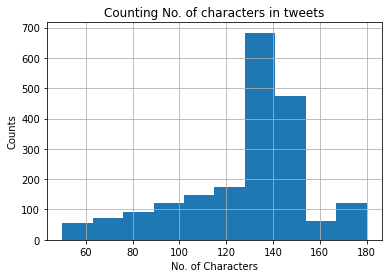

In [11]:
df_filtered.cleaned.str.len().hist()
plt.xlabel('No. of Characters')
plt.ylabel('Counts')
plt.title('Counting No. of characters in tweets');

We get from the plot a skewed gaussian curve, where most of the most characters used in tweets is between 130 and 140.

## Computing feature vectors

We will now convert the 2000 cleaned tweets into feature vectors that can be used to train a network.

**Creating a variable charset containing a string with all of the unique characters used in the cleaned tweets (so it should have a value similar to ' !$,.:;?@ABCDEFG...').**

In [12]:
DF_FILTERED_IND = df_filtered.index

charset = ''
for row in DF_FILTERED_IND:
    txt = df_filtered.loc[row, 'cleaned']
    for char in txt:
        if char not in charset:
            charset += char

In [13]:
charset

'^The racfoDNCimnws,utly*gd.BkvPz!$F@bp;RAKEWSGHMJLxIOUj:?YVqXZQ'

**Converting the tweets to vectors of character indices (starting at 1).**

In [14]:
vec_tweets = []

for tweet in df_filtered.cleaned:
    vec = np.zeros(len(tweet), dtype='uint8')
    for i in range(len(tweet)):
        vec[i] = charset.index(tweet[i])
    vec_tweets.append(vec)

**making each feature vector of length 200, by adding zeroes at the end of the vectors. Then, saving the output matrix of feature vectors in a numpy array data such that each row of data should be the feature vector for one tweet.**

In [15]:
pad_vec_tweets = pad_sequences(vec_tweets, value=0, padding='post', maxlen=200)

In [16]:
matrix_vec_tweets = np.array(pad_vec_tweets)

In [17]:
matrix_vec_tweets.shape

(2000, 200)

We have 2000 rows in the data, and for each row 200 columns as we added now.

**Using the data to generate input and target matrices X and Y**

Removing last column for X (because for each character we want top predict the next character), and removing first column for Y (because the prediction is based on previous character).

In [18]:
X = matrix_vec_tweets[:, :-1]
y_tmp = matrix_vec_tweets[:, 1:]
Y = to_categorical(y_tmp, num_classes=(len(charset)+1))

In [19]:
display(X.shape)
display(Y.shape)

(2000, 199)

(2000, 199, 64)

## Building and training the language model

We will start by using the following imports and hyperparameter settings:

In [20]:
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Embedding, TimeDistributed
hidden_size = 128
embedding_size = 8

We will now build a character-level RNN language model that can learn from the given data.

Building a sequential model *model*, and using *model.add()* adding the following four layers:
  * Embedding layer with output dimension *embedding_size*. 
  * LSTM layer with hidden state dimension *hidden_size*. 
  * Fully-connected layer with softmax activation applied to each LSTM output


In [21]:
model = Sequential()
model.add(Embedding(input_dim=len(charset)+1, output_dim=embedding_size, input_length=X.shape[1], mask_zero=True))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(TimeDistributed(Dense(Y.shape[2], activation='softmax')))

**Compiling the model (model.compile()) with loss function 'categorical_crossentropy' and optimizer 'adam'**

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 199, 8)            512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 199, 128)          70144     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 199, 64)           8256      
Total params: 78,912
Trainable params: 78,912
Non-trainable params: 0
_________________________________________________________________


I assume that the output of the final layer means that per sample we get a matrix of size (199,63) where 199 is the number of features (letters) and 63 is the size of the class labels.  Now, each row (of size 63) has values between 0 and 1, and the row sum is 1, such that the highest value will chose the class label.

##  Generating tweets

Now we will train our language model and use it to generate tweets.

We can generate a tweet using our model as follows:
* Start with the beginning-of-string token '^' as the initial input.
* Predict the distribution of the next character using the model and use the distribution to select the next character in the tweet (can use *np.random.choice()* for this)
* Repeat the process until the end-of-string token '$' is predicted or until 200 characters are generated

**Making a function generate_tweet() that returns the string of a tweet generated by the model, using the above procedure.**

In [36]:
def generate_tweet(start_token='^', end_token='$', max_len=200):
    tweet = start_token
    i = 0
    while len(tweet) < max_len and tweet[-1] != end_token:
        vector = [(charset.index(char) + 1) if char != '0' else '0' for char in tweet]
        prediction = model.predict(pad_sequences([vector], maxlen=max_len - 1, \
                                                 padding='post', value=0))
        tweet += np.random.choice(list('0' + charset), p=prediction[0][i])
        i += 1
    return tweet

In [55]:
tweet = '^'
vector = [(charset.index(char) + 1) if char != '0' else '0' for char in tweet]
prediction = model.predict(pad_sequences([vector], maxlen=199, \
                                                 padding='post', value=0))

In [60]:
prediction[0][0]

array([9.35151689e-09, 1.39780341e-05, 8.60592484e-01, 5.77180795e-02,
       3.12231394e-04, 2.13048849e-02, 3.73054878e-03, 1.45839469e-04,
       8.51409422e-05, 1.29782595e-02, 2.05826618e-05, 7.42635093e-05,
       9.28820882e-05, 3.70205380e-03, 1.00704392e-05, 5.17107721e-04,
       1.10202259e-03, 3.67529028e-05, 8.06371900e-05, 2.71727443e-02,
       1.68645650e-03, 1.56770591e-04, 6.26079971e-04, 2.73171667e-04,
       1.75174755e-05, 3.94021981e-06, 5.13252853e-05, 1.38452247e-04,
       8.44190527e-06, 1.68730494e-05, 3.59783007e-05, 1.81864943e-05,
       4.36432783e-05, 3.21455082e-05, 3.74315678e-05, 6.67453423e-05,
       3.84915948e-05, 1.12874550e-04, 6.24745153e-05, 9.36141005e-04,
       1.11444725e-03, 6.65721163e-05, 3.89232126e-04, 3.70454691e-05,
       3.94187751e-04, 6.35906781e-06, 1.71973859e-03, 6.43114035e-05,
       1.94940185e-05, 5.71557975e-05, 4.54720284e-05, 6.18444930e-04,
       7.86758435e-04, 3.40759987e-04, 6.38967003e-06, 1.88595423e-05,
      

In [38]:
generate_tweet()

'^@xFQIxBluMHGxROknYJw:vbuINpCiDRriQ;kmfdpxVCYJ:Stfpb?NtPiAMQHZxyrqSf!WRgF$'

We get that before training the model the generated tweet is completely random.

**Training the model on X and Y using model.fit, with batch_size = 128 and validation_split = 0.2, for 100 epochs. Then, generating a tweet using the model every 20 epochs.**

In [51]:
from keras.callbacks import Callback

class tweet_generator(Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 20 == 0:
            print(f'{epoch + 1} Epochs done')
            print('----------------')
            for i in range(5):
                print(generate_tweet())
                print()

In [52]:
history = model.fit(X, Y, batch_size=128, epochs=100, validation_split=0.2, callbacks=[tweet_generator()])

Train on 1600 samples, validate on 400 samples
Epoch 1/100
1600/1600 [==============================] - 5s 3ms/step - loss: 1.0319 - val_loss: 1.1237
Epoch 2/100
1600/1600 [==============================] - 7s 4ms/step - loss: 1.0304 - val_loss: 1.1225
Epoch 3/100
1600/1600 [==============================] - 7s 4ms/step - loss: 1.0294 - val_loss: 1.1217
Epoch 4/100
1600/1600 [==============================] - 7s 4ms/step - loss: 1.0285 - val_loss: 1.1227
Epoch 5/100
1600/1600 [==============================] - 7s 4ms/step - loss: 1.0273 - val_loss: 1.1205
Epoch 6/100
1600/1600 [==============================] - 7s 4ms/step - loss: 1.0262 - val_loss: 1.1198
Epoch 7/100
1600/1600 [==============================] - 7s 4ms/step - loss: 1.0249 - val_loss: 1.1186
Epoch 8/100
1600/1600 [==============================] - 6s 4ms/step - loss: 1.0237 - val_loss: 1.1190
Epoch 9/100
1600/1600 [==============================] - 7s 4ms/step - loss: 1.0226 - val_loss: 1.1181
Epoch 10/100
1600/1600 [==

^Thegfnme^ ,ibeurleuThCgeTr geyyegfwme@ C*Tuermm, uhgeGf eNDDeCwere* fCgeufeTr gefcch@rmerwBruCahe@,uei,uTenrle*fe@hruer*af,*ueuTrue* hruz!0000000000000000000000000000000000000000000000000000000000000

^Tfne laf irmghefmeCmeuTheiCttf lenCttewfe* hrue;,@CfenruueuThmeuThueg,CttlekCauf heufurttleb ftwewTfnweofmrtg^ ,ibe hbf usermgekhuuf, senf,tghmeNfiCufecf eiruu:!00000000000000000000000000000000000000

^Thecruheafih hgeuferif,ueileTrgeFNDDeafmlef,ueuTheTrkhea hruhgeuhm he@hruTeb hwCghmuewhhbuCfmer f,meihw,TCm*deWhgewTrCtcyse^TCbefcenCuTeTCieafmth*ch wdeDd!00000000000000000000000000000000000000000000

^The^TheGrmweNTCt  CwBhmueHCBhenrueuThe;hbMCBheufgCkh neuTrueFMh h$

^TrmBeTrkhe@huuhmexeTrkhemC*TueCmuh kChneGCttr leCiif gdeWrgemfne@hwfeCwenrwemfuTr lweuTruetffBCm*ecf ermunCm*ewfnecr ekCarCuCm*etCBherwTChwefceiheufrtteyyyyyyyyyyeyyjyyyermg fCgh whtwehr web hwCghmue

Epoch 61/100
1600/1600 [==============================] - 6s 4ms/step - loss: 0.9698 - val_loss: 1.0886
Epoch 62/100
1600/1

We see that as the training process progress we get more spaces in each tweet, meaning that the model is starting to learn how to seperate words.  We also see that after 100 epochs the model is already putting capital letters after '.', and is starting  sentences with 'The', even if not as a whole word.

**Keep training the model as long as it is underfitting:**

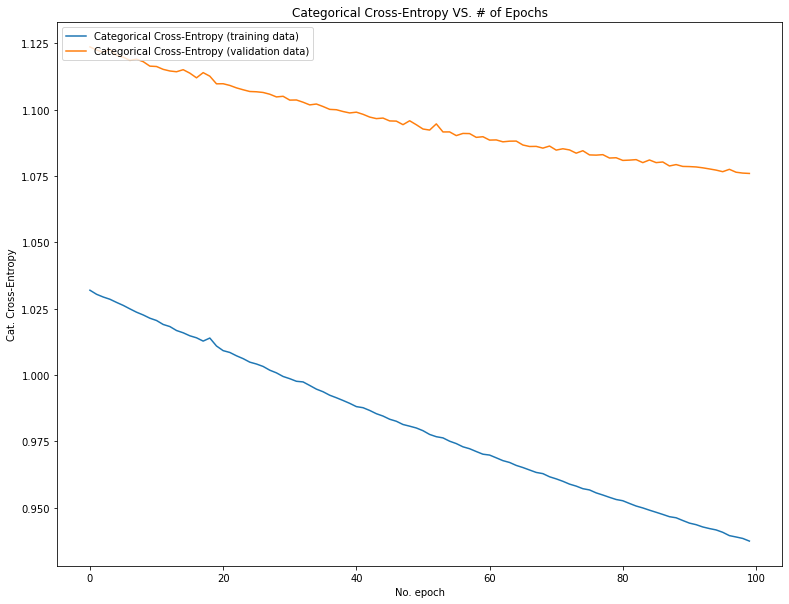

In [61]:
plt.figure(figsize=(13, 10))
plt.plot(history.history['loss'], label='Categorical Cross-Entropy (training data)')
plt.plot(history.history['val_loss'], label='Categorical Cross-Entropy (validation data)')
plt.title('Categorical Cross-Entropy VS. # of Epochs')
plt.ylabel('Cat. Cross-Entropy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

Let's try to evaluate the model with larger number of epochs:

In [63]:
history2 = model.fit(X, Y, batch_size=128, epochs=500, validation_split=0.2, callbacks=[tweet_generator()])

Train on 1600 samples, validate on 400 samples
Epoch 1/500
1600/1600 [==============================] - 4s 3ms/step - loss: 0.9357 - val_loss: 1.0752
Epoch 2/500
1600/1600 [==============================] - 4s 3ms/step - loss: 0.9349 - val_loss: 1.0757
Epoch 3/500
1600/1600 [==============================] - 4s 3ms/step - loss: 0.9342 - val_loss: 1.0761
Epoch 4/500
1600/1600 [==============================] - 5s 3ms/step - loss: 0.9335 - val_loss: 1.0747
Epoch 5/500
1600/1600 [==============================] - 4s 3ms/step - loss: 0.9327 - val_loss: 1.0748
Epoch 6/500
1600/1600 [==============================] - 6s 4ms/step - loss: 0.9321 - val_loss: 1.0740
Epoch 7/500
1600/1600 [==============================] - 5s 3ms/step - loss: 0.9316 - val_loss: 1.0749
Epoch 8/500
1600/1600 [==============================] - 5s 3ms/step - loss: 0.9308 - val_loss: 1.0748
Epoch 9/500
1600/1600 [==============================] - 5s 3ms/step - loss: 0.9304 - val_loss: 1.0762
Epoch 10/500
1600/1600 [==

^TheafibruCfmercuh seYh le,murmweu ,uTsefcchtkh gruCfmeyev hwCghmusenLewhecrmur *heuThe* r,*TefcebthruhwdexenCttermwde.rBhwserueyyyyyyyyyyyeyyjyyjyermg fCseyyyyyyyyyyeyyjyyjyyeCbTfmh!00000000000000000

^Tfmleilecf ,uefkhenCmgeuTheiCwsenThme*fehkhmefmeBhte*,lertrmgemhneghhgeCmeuThhwei fnmeregri*CPh euThe* hrue@hhmemfnemrigweTfuy!000000000000000000000000000000000000000000000000000000000000000000000000

^TCteiheCueCweih hr*tleruerearibrC* hwermgenhtteCmeuTheoha,wTeyHruh^ ,iben fm*hgeuTCmBefcceNDDeafiCm*hgeufe@r*retCBheuTh hd!0000000000000000000000000000000000000000000000000000000000000000000000000000

^Thenh he@huthewfe* fnrwfsecarmgleufirtweufenhrBerueuThefmhefuTh we@rghenf whge@trnweif hebh wfmenTCaTebCtCcCheuTCm*wefceuThseHCaBe@ de.hz!00000000000000000000000000000000000000000000000000Wz!00000000

Epoch 61/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8958 - val_loss: 1.0675
Epoch 62/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8952 - v

Epoch 112/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8679 - val_loss: 1.0671
Epoch 113/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8670 - val_loss: 1.0683
Epoch 114/500
1600/1600 [==============================] - 6s 4ms/step - loss: 0.8665 - val_loss: 1.0674
Epoch 115/500
1600/1600 [==============================] - 6s 4ms/step - loss: 0.8660 - val_loss: 1.0681
Epoch 116/500
1600/1600 [==============================] - 6s 4ms/step - loss: 0.8656 - val_loss: 1.0680
Epoch 117/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8649 - val_loss: 1.0680
Epoch 118/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8644 - val_loss: 1.0675
Epoch 119/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8640 - val_loss: 1.0691
Epoch 120/500
1600/1600 [==============================] - 7s 5ms/step - loss: 0.8636 - val_loss: 1.0686
120 Epochs done
----------------
^The htCw,teuTrueGCwu 

^hgeN ,PseTrweorieH, mueileuThe@hcf hmuwh ef teuThe@h*rufmenTrueuThler*r,merwBr,tgsewru,tuhgeNfm^he^ ,ibsenhe@hruewTfnecf ertteuThecrtuh wdeyyyyyyyyyyeyyjyyjyyermg fCg!00000000000000000000000000000000

^ThecrCtCm*eFmluCihwefmeAr *hseilekfeCma hrBCm*efceoR$

^TheDhneGrmwarwue$

Epoch 221/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8206 - val_loss: 1.0807
Epoch 222/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8206 - val_loss: 1.0797
Epoch 223/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8196 - val_loss: 1.0802
Epoch 224/500
1600/1600 [==============================] - 8s 5ms/step - loss: 0.8187 - val_loss: 1.0808
Epoch 225/500
1600/1600 [==============================] - 8s 5ms/step - loss: 0.8183 - val_loss: 1.0823
Epoch 226/500
1600/1600 [==============================] - 8s 5ms/step - loss: 0.8179 - val_loss: 1.0809
Epoch 227/500
1600/1600 [==============================] - 8s 5ms/step - loss: 0.8178 - val_

1600/1600 [==============================] - 7s 4ms/step - loss: 0.7841 - val_loss: 1.1042
Epoch 331/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7841 - val_loss: 1.1058
Epoch 332/500
1600/1600 [==============================] - 8s 5ms/step - loss: 0.7844 - val_loss: 1.1045
Epoch 333/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7847 - val_loss: 1.1049
Epoch 334/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7845 - val_loss: 1.1070
Epoch 335/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7832 - val_loss: 1.1053
Epoch 336/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7827 - val_loss: 1.1060
Epoch 337/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7824 - val_loss: 1.1066
Epoch 338/500
1600/1600 [==============================] - 6s 4ms/step - loss: 0.7820 - val_loss: 1.1070
Epoch 339/500
1600/1600 [==============================] - 6s 4ms/ste

Epoch 384/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7712 - val_loss: 1.1180
Epoch 385/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7701 - val_loss: 1.1183
Epoch 386/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7693 - val_loss: 1.1186
Epoch 387/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7689 - val_loss: 1.1203
Epoch 388/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7687 - val_loss: 1.1183
Epoch 389/500
1600/1600 [==============================] - 6s 4ms/step - loss: 0.7683 - val_loss: 1.1230
Epoch 390/500
1600/1600 [==============================] - 6s 4ms/step - loss: 0.7707 - val_loss: 1.1207
Epoch 391/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7698 - val_loss: 1.1208
Epoch 392/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7694 - val_loss: 1.1216
Epoch 393/500
1600/1600 [==============================

^TheOdRdRdenCtte@hCm*efmeRih CarmweTr geafibtrCmdeGruTh weufgCuyweCmeuThetrwuebhhbir hgereiCwueghh@ fth*beufeuThlenf BenCuTeU,wuermgef,uz!00000000000000000000000000000000000000000000000000000000000000

^TrmBelf,eufeFHr BreFcfmwummhwTecf eunhe@hhueuThleirmBetC@h wer hef,uh eTCwer@f,ueye^IHKenTheTrkhemfuymgctCuCfmwdeybfeSrgifeArwwCm*ebCtch!00000000000000000000000000000000000000000000000000000000000000

^TheihgCreNr rtCmrefme hrgenf iCm*ef,uerueiheufeHr af gCm*seyenTleCwemfenrweuTheOdWder heuTherttegCgetfmherttdeaf  fatletfwhseCu:!0000000000000000000000000000000000000000000000000000000000000000000000

Epoch 441/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7564 - val_loss: 1.1343
Epoch 442/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7558 - val_loss: 1.1342
Epoch 443/500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7558 - val_loss: 1.1341
Epoch 444/500
1600/1600 [==============================] - 7s 4ms/step - loss: 

1600/1600 [==============================] - 9s 6ms/step - loss: 0.7463 - val_loss: 1.1501
Epoch 496/500
1600/1600 [==============================] - 9s 6ms/step - loss: 0.7460 - val_loss: 1.1505
Epoch 497/500
1600/1600 [==============================] - 9s 5ms/step - loss: 0.7451 - val_loss: 1.1506
Epoch 498/500
1600/1600 [==============================] - 9s 5ms/step - loss: 0.7447 - val_loss: 1.1524
Epoch 499/500
1600/1600 [==============================] - 9s 6ms/step - loss: 0.7447 - val_loss: 1.1510
Epoch 500/500
1600/1600 [==============================] - 10s 6ms/step - loss: 0.7451 - val_loss: 1.1503
500 Epochs done
----------------
^T fuearibruCm*eFRm,uTh CuhweynCmueufer@f,uefceN ffBhgeGCttr leyribpef, ewufbCm*etfkhewTfncseTa,bhgearme hwu fmwzeDfyBeyDyyde^ rge@,wCmheyerifm*z!000000000000000000000000000000000000000000000000000000

^Thegh@hwuefce^TrueCwe* hrueAIJKe*,bwe@,ueTfne*huwecf euThemhnefcelhr weiheCmegfmf wefceF$

^Th e hrttle@rgCm*eF hrtofmrtge^TheghwurmleaTruCrmyewffm

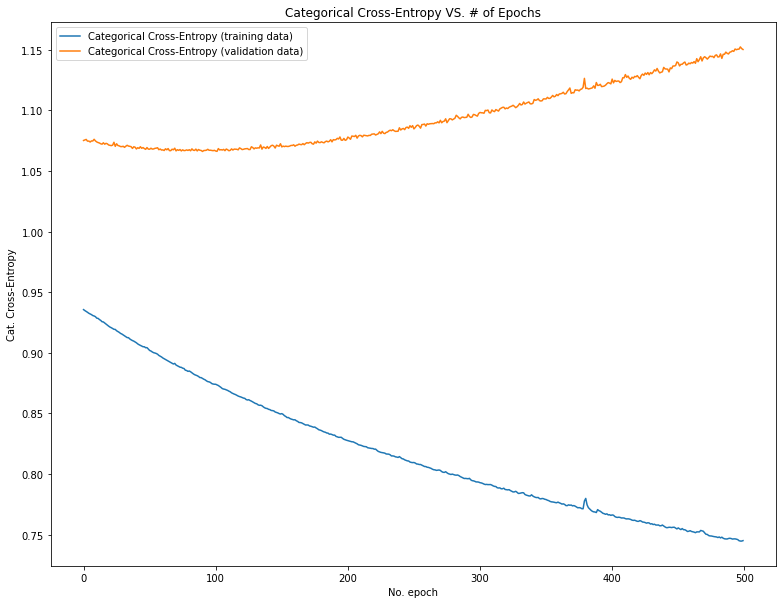

In [64]:
plt.figure(figsize=(13, 10))
plt.plot(history2.history['loss'], label='Categorical Cross-Entropy (training data)')
plt.plot(history2.history['val_loss'], label='Categorical Cross-Entropy (validation data)')
plt.title('Categorical Cross-Entropy VS. # of Epochs')
plt.ylabel('Cat. Cross-Entropy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

From this graph we get that around 100 epochs the model starts overfitting.